# Imports

In [1]:
import keras
import numpy as np
import pandas as pd
import datasets
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

2024-11-12 21:14:45.360979: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 21:14:45.857073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 21:14:46.676940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_t

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

In [4]:
tf.__version__

'2.16.1'

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset

Get the dataset from [here](https://tatoeba.org/en/downloads). Preferably use russian to english translations.

Use a custom tokenizer that can add bos and eos tokens (pass `add_special_tokens=True` when calling the tokenizer to add them).

In [6]:
class Tokenizer(transformers.GPT2Tokenizer):

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        if token_ids_1 is None:
            return [self.bos_token_id, *token_ids_0, self.eos_token_id]

        return [self.bos_token_id, *token_ids_0, self.bos_token_id, *token_ids_1, self.eos_token_id]

In [7]:
tokenizer = Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'Tokenizer'.


In [8]:
dataset = pd.read_csv('Пары предложений на русский-английский - 2024-10-13.tsv', sep='\t',  on_bad_lines='skip', header=None)

In [9]:
dataset

,0,1,2,3
0,243,Один раз в жизни я делаю хорошее дело... И оно...,3257,For once in my life I'm doing a good deed... A...
1,5409,Давайте что-нибудь попробуем!,1276,Let's try something.
2,5410,Мне пора идти спать.,1277,I have to go to sleep.
3,5411,Что ты делаешь?,16492,What are you doing?
4,5411,Что ты делаешь?,511884,What do you make?
...,...,...,...,...
733441,5803241,Будь здоров.,2111946,Bless you.
733442,12780354,Будь здорова.,2111946,Bless you.
733443,12780481,Я хотел бы иметь возможность управлять погодой.,12780477,I wish I could control the weather.
733444,12780663,Нам нужно купить им подарок.,3917718,We need to buy a gift for them.


In [10]:
dataset = dataset.rename(columns={0: 'id_ru', 1: 'text_ru', 2: 'id_en', 3: 'text_en'})

In [11]:
dataset

,id_ru,text_ru,id_en,text_en
0,243,Один раз в жизни я делаю хорошее дело... И оно...,3257,For once in my life I'm doing a good deed... A...
1,5409,Давайте что-нибудь попробуем!,1276,Let's try something.
2,5410,Мне пора идти спать.,1277,I have to go to sleep.
3,5411,Что ты делаешь?,16492,What are you doing?
4,5411,Что ты делаешь?,511884,What do you make?
...,...,...,...,...
733441,5803241,Будь здоров.,2111946,Bless you.
733442,12780354,Будь здорова.,2111946,Bless you.
733443,12780481,Я хотел бы иметь возможность управлять погодой.,12780477,I wish I could control the weather.
733444,12780663,Нам нужно купить им подарок.,3917718,We need to buy a gift for them.


In [12]:
dataset.isna().sum()

id_ru      0
text_ru    0
id_en      0
text_en    0
dtype: int64

In [23]:
dataset['text_ru'].apply(lambda x: len(x)).max()

837

In [12]:
dataset['text_ru'].apply(lambda x: len(x)).idxmax()

608846

In [10]:
dataset.iloc[608846, 3]

'I am a Jew. Hath not a Jew eyes? Hath not a Jew hands, organs, dimensions, senses, affections, passions? Fed with the same food, hurt with the same weapons, subject to the same diseases, healed by the same means, warmed and cooled by the same winter and summer, as a Christian is? If you prick us, do we not bleed? If you tickle us, do we not laugh? If you poison us, do we not die? And if you wrong us, shall we not revenge? If we are like you in the rest, we will resemble you in that. If a Jew wrong a Christian, what is his humility? Revenge. If a Christian wrong a Jew, what should his sufferance be by Christian example? Why, revenge. The villainy you teach me, I will execute, and it shall go hard but I will better the instruction.'

In [15]:
dataset['text_ru'].apply(lambda x: len(x)).median()

28.0

In [18]:
(dataset['text_ru'].apply(lambda x: len(x)) > 200).sum()

453

<Axes: >

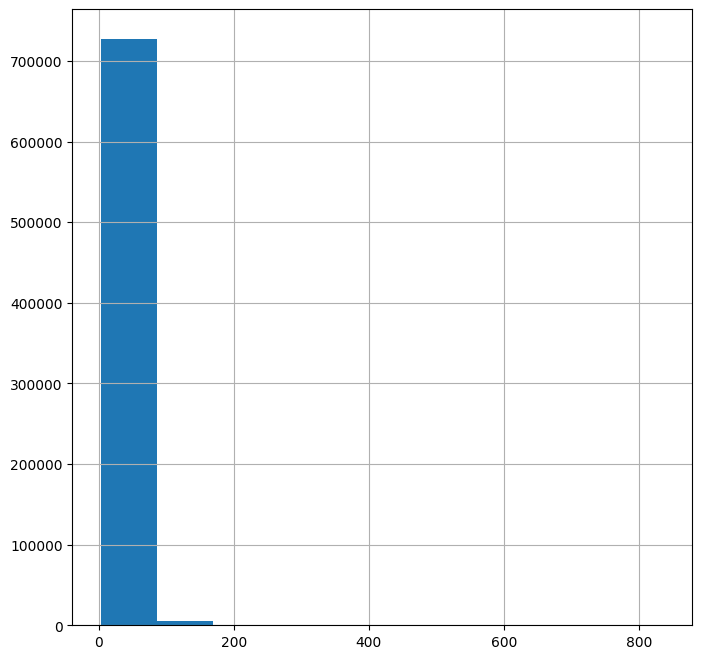

In [16]:
dataset['text_ru'].apply(lambda x: len(x)).hist(figsize=(8,8))

---
Обрезаю очень длинные текста

In [12]:
dataset2 = dataset[dataset['text_ru'].apply(lambda x: len(x)) <= 200]

In [13]:
dataset2[dataset2['text_en'].apply(lambda x: len(x)) > 200]

,id_ru,text_ru,id_en,text_en
1633,400671,"На душе становится тепло, когда ты слышишь в п...",400674,"It warms your heart to, when listening to a so..."
1634,400671,"На душе становится тепло, когда ты слышишь в п...",494506,"It warms your heart when, while listening to a..."
1635,400671,"На душе становится тепло, когда ты слышишь в п...",495180,While listening to songs in a what is supposed...
1686,402065,В Китае используется большое количество иерогл...,401970,"In China, there is a large number of character..."
12169,510907,"Дом птицы - лес, дом рыбы - река, дом пчелы - ...",485186,"The birds' home is in the forest, the fish's h..."
...,...,...,...,...
667027,11715247,В матче за звание чемпиона мира ФИДЕ 2023 по ш...,11715230,The match for the FIDE 2023 World Chess Champi...
706703,12333670,"В этом мире нет ничего прекраснее, чем слышать...",12333611,"In this world, nothing is more beautiful than ..."
706732,12334059,Галилео Галилей был итальянским астрономом и в...,4310535,Galileo Galilei was an Italian astronomer and ...
706737,12334074,Дерзость Цезаря была началом выдающейся военно...,4277919,Caesar’s audacity was the beginning of a very ...


In [27]:
dataset2.loc[1633, 'text_ru'], dataset2.loc[1633, 'text_en'],

('На душе становится тепло, когда ты слышишь в песне на (казалось бы!) чужом языке: словацком, македонском, словенском, — знакомые с детства слова и даже понимаешь целые фразы.',
 'It warms your heart to, when listening to a song in a (seemingly!) foreign language like Slovak, Macedonian, Slovenian, hear words you have known since your childhood and even understand whole phrases.')

In [67]:
a = tokenizer(list(dataset2['text_ru']), add_special_tokens=False)['input_ids']

In [68]:
np.median(list(map(len, a)))

32.0

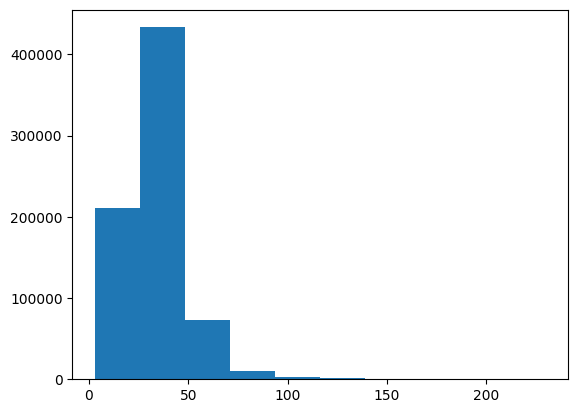

In [69]:
plt.hist(list(map(len, a)))
plt.show()

In [74]:
dataset2['text_en'].apply(lambda x: len(x)).median()

29.0

In [75]:
(dataset2['text_en'].apply(lambda x: len(x)) > 200).sum()

72

<Axes: >

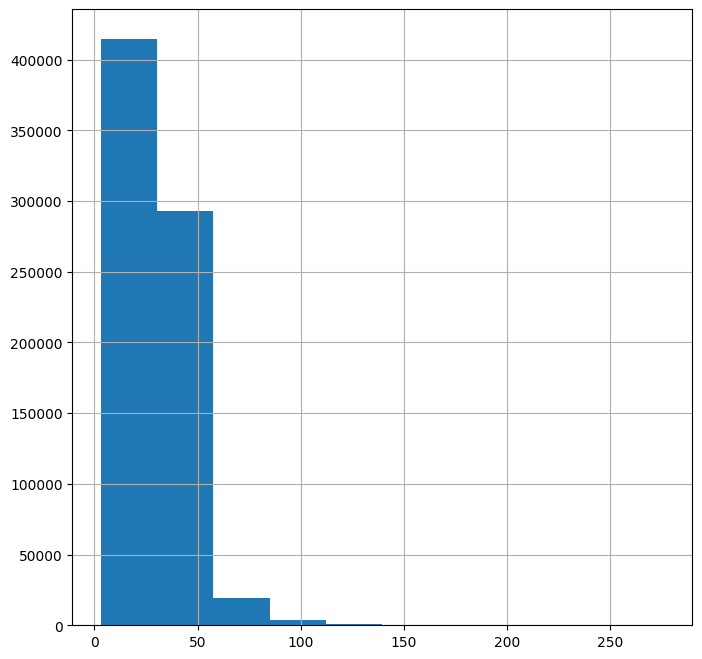

In [76]:
dataset2['text_en'].apply(lambda x: len(x)).hist(figsize=(8,8))

In [60]:
b = tokenizer(list(dataset2['text_en']), add_special_tokens=True)['input_ids']

In [77]:
np.median(list(map(len, b)))

9.0

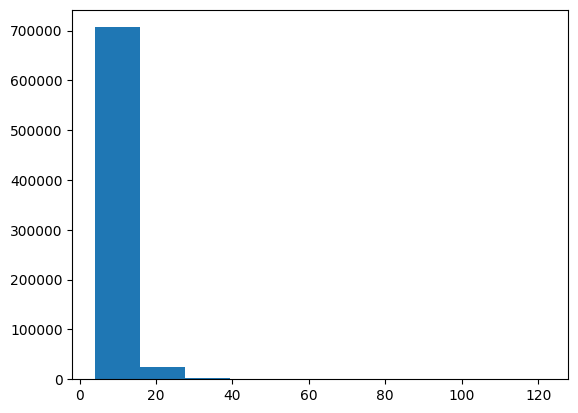

In [78]:
plt.hist(list(map(len, b)))
plt.show()

Since the dataset is rather large, you can omit the validation dataset and just use a set of test sentences after the training.

Create a dataset that returns the following
* A pair of tensors `((None, L), (None, P))` -- input sequence of tokens and output sequence of tokens to be fed into decoder (this should start with the BOS token)
* A tensor `(None, P)` -- output sequence of tokens to be predicted (this should end with EOS token)
* A tensor `(None, P)` -- a masking tensor marking padded tokens with 0

In [13]:
token_ru = tokenizer(list(dataset2['text_ru']), truncation=True, padding='max_length', max_length=32, return_tensors='np', add_special_tokens=False)['input_ids'].astype(np.int32)
token_en = tokenizer(list(dataset2['text_en']), truncation=True, padding='max_length', max_length=16, return_tensors='np', add_special_tokens=True)['input_ids'].astype(np.int32)

In [14]:
def get_dataset_split(
    tokens_ru: np.ndarray[np.ndarray[int]],
    tokens_en: np.ndarray[np.ndarray[int]],
    shuffle: bool = True,
    seed: int | None = 747,
    subset: str | None = None,
    test_split: float | None = None,
    batch_size: int = 64
):

    if (subset is not None) != (test_split is not None):
        raise ValueError("If 'subset' is set, 'test_split' must be set, and inversely.")

    if subset not in {"train", "test", None}:
        raise ValueError(
            '`subset` must be either "train", "test" 'f"received: {subset}"
        )

    if shuffle:
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(tokens_ru), size=len(tokens_ru), replace=False)
        tokens_ru = tokens_ru[idx]
        tokens_en = tokens_en[idx]

    if test_split is not None:  
        num_samples = int((1 - test_split) * len(tokens_ru))
        
        if subset == 'train':
            tokens_ru, tokens_en = tokens_ru[:num_samples], tokens_en[:num_samples]
        elif subset == 'test':
            tokens_ru, tokens_en = tokens_ru[num_samples:], tokens_en[num_samples:]

    tokens_ru_dataset = tf.data.Dataset.from_tensor_slices(tokens_ru)
    tokens_en_dataset = tf.data.Dataset.from_tensor_slices(tokens_en)
    
    output_tokens_en = tokens_en_dataset.map(lambda x: x[1:])
    input_tokens_en = tokens_en_dataset.map(lambda x: x[:-1])
    
    tokens_en_range = tf.range(input_tokens_en.element_spec.shape[0])
    mask_tokens_en = output_tokens_en.map(
        lambda x: tf.cast(
            tokens_en_range <= tf.math.reduce_sum(
                tf.cast(
                    x != tokenizer.pad_token_id,
                    tf.int32
                )
            ),
            tf.float32
        )
    )
    
    dataset = tf.data.Dataset.zip((
        tf.data.Dataset.zip((tokens_ru_dataset, input_tokens_en)),
        output_tokens_en,
        mask_tokens_en
    )).batch(batch_size)
    
    return dataset

In [15]:
train_dataset = get_dataset_split(token_ru, token_en, shuffle=True, seed=747, subset='train', test_split=0.3, batch_size=256)

2024-11-12 21:17:38.251856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 21:17:38.252010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 21:17:38.252040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 21:17:38.252540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-12 21:17:38.252569: I tensorflow/core/common_runtime/gpu/gpu

In [16]:
train_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), TensorSpec(shape=(None, 15), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 15), dtype=tf.int32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [17]:
inputs, out, msk = next(iter(train_dataset))

In [18]:
inputs

(<tf.Tensor: shape=(256, 32), dtype=int32, numpy=
 array([[  140,   252, 22177, ..., 50256, 50256, 50256],
        [  140,   253, 21169, ...,   220, 21727, 20375],
        [  140,    94, 43666, ..., 50256, 50256, 50256],
        ...,
        [  140,   253, 15166, ..., 50256, 50256, 50256],
        [  140,   251, 16843, ..., 16142, 20375, 16843],
        [  140,    95, 45035, ..., 50256, 50256, 50256]], dtype=int32)>,
 <tf.Tensor: shape=(256, 15), dtype=int32, numpy=
 array([[50256,  1544, 21893, ..., 50256, 50256, 50256],
        [50256,  5703,  2666, ..., 50256, 50256, 50256],
        [50256,  1858,   338, ..., 50256, 50256, 50256],
        ...,
        [50256,  2504,   338, ..., 50256, 50256, 50256],
        [50256,  4366,  1402, ..., 50256, 50256, 50256],
        [50256, 11633,    77, ..., 50256, 50256, 50256]], dtype=int32)>)

In [19]:
out, msk

(<tf.Tensor: shape=(256, 15), dtype=int32, numpy=
 array([[ 1544, 21893,   757, ..., 50256, 50256, 50256],
        [ 5703,  2666,   340, ..., 50256, 50256, 50256],
        [ 1858,   338,   645, ..., 50256, 50256, 50256],
        ...,
        [ 2504,   338,  1521, ..., 50256, 50256, 50256],
        [ 4366,  1402, 17038, ..., 50256, 50256, 50256],
        [11633,    77,   470, ..., 50256, 50256, 50256]], dtype=int32)>,
 <tf.Tensor: shape=(256, 15), dtype=float32, numpy=
 array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)>)

In [20]:
out[0] * tf.cast(msk[0], tf.int32)

<tf.Tensor: shape=(15,), dtype=int32, numpy=
array([ 1544, 21893,   757,    13, 50256,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)>

In [21]:
test_dataset = get_dataset_split(token_ru, token_en, shuffle=True, seed=747, subset='test', test_split=0.3, batch_size=256)

# Model

Create a model for training. The model should have two inputs: input sequence `(None, L)` and output sequence`(None, P)`. The model output is a single tensor `(None, P)` logits (or probabilities) of the next token predicted for each input one.

In [24]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '_') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

Try to add attention to your model (for example [additive attention](https://keras.io/api/layers/attention_layers/additive_attention/)), does it perform better?

In [113]:
def get_model(
    units: int,
    n_tokens: int,
    n_labels: int,
    n_stacks: int = 1,
    bidirectional: bool = False,
    name: str | None = None,
    cell_type: type[tf.keras.layers.Layer] = tf.keras.layers.LSTMCell,
    attention_flg = False
) -> tf.keras.Model:
    '''Creates a model with RNN architecture for sequence to sequence classification.

    Arguments:
        units: dimensionality of RNN cells
        n_tokens: number of tokens in the tokenizer dictionary
        n_labels: number of labels to be predicted
        n_stacks: number of RNN cells in the stack (1 -- no stacking)
        bidirectional: whether or not the model is bidirectional
        name: the model name
        cell_type: type of a cell to use, either keras.layers.LSTMCell or keras.layers.GRUCell

    Returns:
        The model'''

    inputs_encoder = tf.keras.layers.Input((None, ), dtype=tf.int32, name=get_name(name, 'input_encoder'))
    embedding = tf.keras.layers.Embedding(n_tokens, units, name=get_name(name, 'embedding_encoder'))(inputs_encoder)
    
    if bidirectional:
        rnn_layer, *s = tf.keras.layers.Bidirectional(
            tf.keras.layers.RNN(
                [cell_type(units) for _ in range(n_stacks)],
                return_sequences=True,
                return_state=True,
                name=get_name(name, 'rnn_encoder')
            ), name=get_name(name, 'bidirectional')
        )(embedding)

        if cell_type == tf.keras.layers.LSTMCell:
                forward_states = s[:n_stacks]
                backward_states = s[n_stacks:]
                
                initial_state = [
                    [
                        tf.keras.layers.Concatenate(axis=-1)([forward[0], backward[0]]),
                        tf.keras.layers.Concatenate(axis=-1)([forward[1], backward[1]])
                    ]
                    for forward, backward in zip(forward_states, backward_states)
                ]
        else:
            forward_states = s[:n_stacks]
            backward_states = s[n_stacks:]
                
            initial_state = [tf.keras.layers.Concatenate(axis=-1)([forward, backward]) for forward, backward in zip(forward_states, backward_states)]

        # if cell_type == tf.keras.layers.LSTMCell:
        #     s = [el for elem in s for el in (elem if isinstance(elem, list) else [elem])]
        #     forward_end = s[len(s)//2 - 2: len(s)//2]
        #     backword_end = s[len(s) - 2:]

        #     initial_state = [tf.keras.layers.Concatenate(axis=-1)([forward_end[0], backword_end[0]]),
        #                      tf.keras.layers.Concatenate(axis=-1)([forward_end[1], backword_end[1]])]
        #     initial_state = [initial_state] * n_stacks

        # else:
        #     forward_end = s[len(s)//2 - 1]
        #     backword_end = s[len(s) - 1]
                
        #     initial_state = [tf.keras.layers.Concatenate(axis=-1)([forward_end, backword_end])]
        #     initial_state = initial_state * n_stacks
            
    else:
        rnn_layer, *s = tf.keras.layers.RNN(
            [cell_type(units) for _ in range(n_stacks)],
            return_sequences=True,
            return_state=True,
            name=get_name(name, 'rnn_encoder')
        )(embedding)
        initial_state = s

    
    inputs_decoder = tf.keras.layers.Input((None, ), dtype=tf.int32, name=get_name(name, 'input_decoder')) 
    embedding_dec = tf.keras.layers.Embedding(n_tokens, units, name=get_name(name, 'embedding_decoder'))(inputs_decoder)
    
    dec_units = 2 * units if bidirectional else units
    
    rnn = tf.keras.layers.RNN(
        [cell_type(dec_units) for _ in range(n_stacks)],
        return_sequences=True,
        name=get_name(name, 'rnn_decoder')
    )(embedding_dec, initial_state=initial_state)
    
    if attention_flg: 
        attention_layer =  tf.keras.layers.AdditiveAttention(name=get_name(name, 'attention'))([rnn, rnn_layer])
        attention_context = tf.keras.layers.Concatenate(axis=-1, name=get_name(name, 'rnn_and_attention'))([rnn, attention_layer])
        output = tf.keras.layers.Dense(n_labels, name=get_name(name, 'output'))(attention_context)
    else:   
        output = tf.keras.layers.Dense(n_labels, name=get_name(name, 'output'))(rnn)

    return tf.keras.Model(inputs=(inputs_encoder, inputs_decoder), outputs=output, name=name)

In [114]:
models = get_model(128, tokenizer.vocab_size, tokenizer.vocab_size, n_stacks=1, bidirectional=True, name='Seq2Seq', cell_type=tf.keras.layers.LSTMCell, attention_flg=True)

In [33]:
models.summary()

Model: "Seq2Seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_input_enco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_input_en… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_input_deco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_bidirectio… │ [(None, 256),     │    263,168 │ Seq2Seq_embeddin… │
│ (Bidirectional)     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_input_de… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_decoder │ (None, None, 256) │    394,240 │ Seq2Seq_embeddin… │
│ (RNN)               │                   │            │ concatenate_7[0]… │
│                     │                   │            │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention   │ (None, None, 256) │        256 │ Seq2Seq_rnn_deco… │
│ (AdditiveAttention) │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_and_at… │ (None, None, 512) │          0 │ Seq2Seq_rnn_deco… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_output      │ (None, None,      │ 25,781,841 │ Seq2Seq_rnn_and_… │
│ (Dense)             │ 50257)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,305,297 (149.94 MB)

 Trainable params: 39,305,297 (149.94 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
(input_ru, input_en), output_en, mask = next(iter(train_dataset))

In [19]:
input_ru, input_en

(<tf.Tensor: shape=(64, 32), dtype=int32, numpy=
 array([[  140,   252, 22177, ..., 50256, 50256, 50256],
        [  140,   253, 21169, ...,   220, 21727, 20375],
        [  140,    94, 43666, ..., 50256, 50256, 50256],
        ...,
        [  140,   255, 20375, ..., 45367, 12466,   120],
        [  140,    94, 25443, ...,   220,   141,   235],
        [  140,   242, 16142, ..., 15166, 21727, 20375]], dtype=int32)>,
 <tf.Tensor: shape=(64, 15), dtype=int32, numpy=
 array([[50256,  1544, 21893,   757,    13, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256],
        [50256,  5703,  2666,   340,   319,   616,  6915,    13, 50256,
         50256, 50256, 50256, 50256, 50256, 50256],
        [50256,  1858,   338,   645,   779, 13774,   625,   599,  2326,
          7545,    13, 50256, 50256, 50256, 50256],
        [50256,    40, 13030,  4186,   407,   284,  2652,   503,  2739,
           379,  1755,    13, 50256, 50256, 50256],
        [50256,  6090,   345,  3708

In [34]:
models([(input_ru, input_en)])

<tf.Tensor: shape=(64, 15, 50257), dtype=float32, numpy=
array([[[-2.46271607e-03, -9.56725096e-04, -1.77378696e-03, ...,
          8.25832249e-04, -3.62789142e-03,  5.47599397e-04],
        [-2.14463286e-03, -6.28471025e-04, -1.71366613e-03, ...,
          3.79801961e-04, -2.88090599e-03,  6.68503926e-04],
        [-1.29296537e-03, -1.77024020e-04, -1.26775319e-03, ...,
          6.90211542e-04, -1.79957598e-03,  7.09687243e-04],
        ...,
        [-2.59824505e-04, -2.59114109e-04, -2.51226639e-03, ...,
          2.00330094e-03,  6.10027462e-04, -8.61629087e-04],
        [-2.41230096e-04, -2.97095423e-04, -2.58331117e-03, ...,
          2.08623358e-03,  6.70696667e-04, -9.04475746e-04],
        [-2.24289164e-04, -3.25460715e-04, -2.64031300e-03, ...,
          2.15441897e-03,  7.22449506e-04, -9.37287114e-04]],

       [[ 5.75040991e-04,  6.76668016e-04, -3.08478280e-04, ...,
          7.12696696e-04,  9.75751100e-05,  1.20589568e-04],
        [-1.15868112e-04,  1.59674324e-04, -5.

# Training

Train your model using teacher forcing. The idea is that the model predicts the next token that should follow, so one part of the model (called encoder) reads the text and output some state containing information about the text read. The other part of the model (called decoder) reads and already generated text (or in case of the teacher forcing the expected output) and predicts the next token for each one. 

---

При обучении моделей на выходе энкодера бралось только последнее состояние и "размножалось" в количестве используемых ячеек и подавалось на вход декодеру

In [115]:
model1 = get_model(128,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=2,
                   bidirectional=True,
                   name='Seq2Seq',
                   cell_type=tf.keras.layers.LSTMCell,
                   attention_flg=False
)

model1.summary()

Model: "Seq2Seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_input_enco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_input_en… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_input_deco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_bidirectio… │ [(None, None,     │    526,336 │ Seq2Seq_embeddin… │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_input_de… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_29      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_decoder │ (None, None, 256) │    919,552 │ Seq2Seq_embeddin… │
│ (RNN)               │                   │            │ concatenate_26[0… │
│                     │                   │            │ concatenate_27[0… │
│                     │                   │            │ concatenate_28[0… │
│                     │                   │            │ concatenate_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_output      │ (None, None,      │ 12,916,049 │ Seq2Seq_rnn_deco… │
│ (Dense)             │ 50257)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,227,729 (103.87 MB)

 Trainable params: 27,227,729 (103.87 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [27]:
print(f'model training: {model1.name}')
history_1 = model1.fit(train_dataset, batch_size=256, epochs=15)

model training: Seq2Seq
Epoch 1/15


I0000 00:00:1731027567.663516    1287 service.cc:145] XLA service 0x14f89350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731027567.663555    1287 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-08 10:59:27.765410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1731027568.117567    1287 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-08 10:59:28.305712: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1731027569.077644    2091 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_173', 84 bytes spill stores, 84 bytes spill loads

I0000 00

2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5307 - loss: 2.8590

W0000 00:00:1731027716.426898    1289 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731027717.323745    2845 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_177', 44 bytes spill stores, 32 bytes spill loads

I0000 00:00:1731027718.138031    2844 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_177', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731027718.246785    2847 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_174', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731027718.763870    2840 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1731027718.881546    2851 asm_

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 158s 74ms/step - accuracy: 0.5307 - loss: 2.8584
Epoch 2/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 149s 74ms/step - accuracy: 0.7021 - loss: 1.5326
Epoch 3/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 153s 76ms/step - accuracy: 0.6467 - loss: 1.1980
Epoch 4/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 153s 76ms/step - accuracy: 0.6009 - loss: 1.0139
Epoch 5/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 155s 77ms/step - accuracy: 0.5651 - loss: 0.8971
Epoch 6/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.5516 - loss: 0.8157
Epoch 7/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - accuracy: 0.5298 - loss: 0.7544
Epoch 8/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 155s 78ms/step - accuracy: 0.5368 - loss: 0.7066
Epoch 9/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 155s 77ms/step - accuracy: 0.5253 - loss: 0.6667
Epoch 10/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - accuracy: 0.5279 - loss: 0.6336
Epoch 11/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - accuracy: 0.5331 - loss: 0.6051
Epoch 12

In [28]:
print('Дообучение модели')
print(f'model training: {model1.name}')
history_1 = model1.fit(train_dataset, batch_size=256, epochs=15)

Дообучение модели
model training: Seq2Seq
Epoch 1/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 146s 73ms/step - accuracy: 0.5383 - loss: 0.5051
Epoch 2/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 150s 75ms/step - accuracy: 0.5397 - loss: 0.4904
Epoch 3/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 155s 77ms/step - accuracy: 0.5421 - loss: 0.4773
Epoch 4/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.5446 - loss: 0.4651
Epoch 5/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - accuracy: 0.5474 - loss: 0.4537
Epoch 6/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.5528 - loss: 0.4429
Epoch 7/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.5532 - loss: 0.4329
Epoch 8/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.5543 - loss: 0.4234
Epoch 9/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.5571 - loss: 0.4148
Epoch 10/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.5584 - loss: 0.4068
Epoch 11/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 157s

In [29]:
print('-'*30)
model1.save_weights(f'30_new_LSTM_{model1.name}.weights.h5')
print(f'Веса модели 30_new_LSTM_{model1.name} сохранены')

------------------------------
Веса модели 30_new_LSTM_Seq2Seq сохранены


---

In [116]:
model2 = get_model(256,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=2,
                   bidirectional=True,
                   name='Seq2Seq',
                   cell_type=tf.keras.layers.LSTMCell,
                   attention_flg=True
)

model2.summary()

Model: "Seq2Seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_input_enco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 256) │ 12,865,792 │ Seq2Seq_input_en… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_input_deco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_bidirectio… │ [(None, None,     │  2,101,248 │ Seq2Seq_embeddin… │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 256) │ 12,865,792 │ Seq2Seq_input_de… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_decoder │ (None, None, 512) │  3,674,112 │ Seq2Seq_embeddin… │
│ (RNN)               │                   │            │ concatenate_30[0… │
│                     │                   │            │ concatenate_31[0… │
│                     │                   │            │ concatenate_32[0… │
│                     │                   │            │ concatenate_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention   │ (None, None, 512) │        512 │ Seq2Seq_rnn_deco… │
│ (AdditiveAttention) │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_and_at… │ (None, None,      │          0 │ Seq2Seq_rnn_deco… │
│ (Concatenate)       │ 1024)             │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_output      │ (None, None,      │ 51,513,425 │ Seq2Seq_rnn_and_… │
│ (Dense)             │ 50257)            │            │                 

 Total params: 83,020,881 (316.70 MB)

 Trainable params: 83,020,881 (316.70 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [31]:
print(f'model training: {model2.name}')
history_2 = model2.fit(train_dataset, batch_size=256, epochs=15)

model training: Seq2Seq
Epoch 1/15


W0000 00:00:1730986736.964115   37220 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6026 - loss: 2.5358

W0000 00:00:1730987184.238713   37222 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 471s 223ms/step - accuracy: 0.6026 - loss: 2.5353
Epoch 2/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 446s 222ms/step - accuracy: 0.7253 - loss: 1.3815
Epoch 3/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 444s 222ms/step - accuracy: 0.6500 - loss: 1.0143
Epoch 4/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 446s 222ms/step - accuracy: 0.5907 - loss: 0.8181
Epoch 5/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 445s 222ms/step - accuracy: 0.5883 - loss: 0.6966
Epoch 6/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 445s 222ms/step - accuracy: 0.5864 - loss: 0.6097
Epoch 7/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 444s 222ms/step - accuracy: 0.5854 - loss: 0.5447
Epoch 8/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 446s 222ms/step - accuracy: 0.5951 - loss: 0.4915
Epoch 9/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 445s 222ms/step - accuracy: 0.6004 - loss: 0.4482
Epoch 10/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 445s 222ms/step - accuracy: 0.6105 - loss: 0.4100
Epoch 11/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 444s 222ms/step - accuracy: 0.6119 - loss: 0.37

In [33]:
print('Дообучение дополнительных 15 эпох модели')
print(f'model training: {model2.name}')
history_2 = model2.fit(train_dataset, batch_size=256, epochs=15)

Дообучение дополнительных 15 эпох модели
model training: Seq2Seq
Epoch 1/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 439s 219ms/step - accuracy: 0.6333 - loss: 0.2608
Epoch 2/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 429s 214ms/step - accuracy: 0.6311 - loss: 0.2457
Epoch 3/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 396s 198ms/step - accuracy: 0.6318 - loss: 0.2295
Epoch 4/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 387s 193ms/step - accuracy: 0.6354 - loss: 0.2155
Epoch 5/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 387s 193ms/step - accuracy: 0.6357 - loss: 0.2040
Epoch 6/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 387s 193ms/step - accuracy: 0.6340 - loss: 0.1922
Epoch 7/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 439s 219ms/step - accuracy: 0.6430 - loss: 0.1825
Epoch 8/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 446s 222ms/step - accuracy: 0.6461 - loss: 0.1725
Epoch 9/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 448s 223ms/step - accuracy: 0.6482 - loss: 0.1649
Epoch 10/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 447s 223ms/step - accuracy: 0.6440 - loss: 0.1571
Epoch 11/15
20

In [34]:
print('-'*30)
model2.save_weights(f'30_new_attention_LSTM_{model2.name}.weights.h5')
print(f'Веса модели 30_new_attention_LSTM_{model2.name} сохранены')

------------------------------
Веса модели 30_new_attention_LSTM_Seq2Seq сохранены


---

In [118]:
model3 = get_model(128,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=4,
                   bidirectional=True,
                   name='Seq2Seq_attention_GRUCell',
                   cell_type=tf.keras.layers.GRUCell,
                   attention_flg=True
)

model3.summary()

Model: "Seq2Seq_attention_GRUCell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_attention_… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_attentio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ [(None, None,     │    792,576 │ Seq2Seq_attentio… │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_attentio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_38      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_39      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_40      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_41      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 256) │  1,480,704 │ Seq2Seq_attentio… │
│ (RNN)               │                   │            │ concatenate_38[0… │
│                     │                   │            │ concatenate_39[0… │
│                     │                   │            │ concatenate_40[0… │
│                     │                   │            │ concatenate_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 256) │        256 │ Seq2Seq_attentio… │
│ (AdditiveAttention) │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 512) │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None,      │ 25,781,841 │ Seq2Seq_attentio… │
│ (Dense)             │ 50257)            │            │                 

 Total params: 40,921,169 (156.10 MB)

 Trainable params: 40,921,169 (156.10 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [37]:
print(f'model training: {model3.name}')
history_3 = model3.fit(train_dataset, batch_size=256, epochs=15)

model training: Seq2Seq_attention_GRUCell
Epoch 1/15


W0000 00:00:1731000000.546222   37219 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731000001.852334   97356 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_488', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731000002.680821   97362 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_488', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1731000003.363254   97361 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_472', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1731000003.528791   97364 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1731000003.552923   97354 

2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4927 - loss: 2.7459

W0000 00:00:1731000287.587403   37217 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731000289.279472   98595 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_475', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1731000289.410082   98597 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 28 bytes spill stores, 28 bytes spill loads

I0000 00:00:1731000289.761581   98588 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_475', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1731000289.787169   98601 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731000290.311107   98594 asm_compil

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 304s 143ms/step - accuracy: 0.4928 - loss: 2.7453
Epoch 2/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 282s 141ms/step - accuracy: 0.6504 - loss: 1.4874
Epoch 3/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.5592 - loss: 1.1661
Epoch 4/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 282s 141ms/step - accuracy: 0.5272 - loss: 0.9871
Epoch 5/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 141ms/step - accuracy: 0.5313 - loss: 0.8734
Epoch 6/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 142ms/step - accuracy: 0.5581 - loss: 0.7947
Epoch 7/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.5620 - loss: 0.7379
Epoch 8/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.5624 - loss: 0.6966
Epoch 9/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.5737 - loss: 0.6638
Epoch 10/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 282s 141ms/step - accuracy: 0.5669 - loss: 0.6360
Epoch 11/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 141ms/step - accuracy: 0.5642 - loss: 0.61

In [39]:
print('Дообучение дополнительных 15 эпох модели')
print(f'model training: {model3.name}')
history_3 = model3.fit(train_dataset, batch_size=256, epochs=15)

Дообучение дополнительных 15 эпох модели
model training: Seq2Seq_attention_GRUCell
Epoch 1/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.6260 - loss: 0.5301
Epoch 2/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 141ms/step - accuracy: 0.6333 - loss: 0.5150
Epoch 3/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 141ms/step - accuracy: 0.6317 - loss: 0.5041
Epoch 4/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 141ms/step - accuracy: 0.6343 - loss: 0.4943
Epoch 5/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 282s 140ms/step - accuracy: 0.6399 - loss: 0.4855
Epoch 6/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 282s 141ms/step - accuracy: 0.6351 - loss: 0.4802
Epoch 7/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 142ms/step - accuracy: 0.6452 - loss: 0.4735
Epoch 8/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 142ms/step - accuracy: 0.6463 - loss: 0.4641
Epoch 9/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.6412 - loss: 0.4571
Epoch 10/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 282s 141ms/step - accuracy: 0.6396 - loss: 0.4

In [40]:
print('-'*30)
model3.save_weights(f'30_new_{model3.name}.weights.h5')
print(f'Веса модели 30_new_{model3.name} сохранены')

------------------------------
Веса модели 30_new_Seq2Seq_attention_GRUCell сохранены


# Testing

Make a function for text translation. Translate some text and evaluate model performance.

Take note that your model is set for training. During the inference process you will have to use parts of the model independently (including the RNN cells).

In [146]:
def translate(
    text: str,
    tokenizer: Tokenizer,
    model: keras.Model,
    max_len: int = 20,
    type_cell: str = 'LSTM',
    name_model: str = 'Seq2Seq',
    flg_attention: bool = True
) -> str:
    '''Predicts `text`translation using the `model`.

    Arguments:
        text: text to be translated
        tokenizer: tokenizer to use
        model: model ot use
        max_len: maximum length of the prediction (in tokens)

    Returns:
        tranlated text'''

    encorder_emm = model.get_layer(f'{name_model}_embedding_encoder')
    encoder_rnn = model.get_layer(f'{name_model}_bidirectional')

    input_seq =  tokenizer(text, return_tensors='np', add_special_tokens=False)['input_ids'].astype(np.int32)
    encoder_outputs, *states = encoder_rnn(encorder_emm(input_seq))

    if type_cell == 'LSTM':
        forwards = states[len(states) // 2-1]
        bacwards = states[len(states) - 1]
        initial_state = [tf.keras.ops.concatenate([forwards[0], bacwards[0]], axis=-1),
                         tf.keras.ops.concatenate([forwards[1], bacwards[1]], axis=-1),]
        initial_state = [initial_state] * (len(states) // 2)
    else:
        forwards = states[len(states) // 2 - 1]
        bacwards = states[len(states) - 1]
        initial_state = [tf.keras.ops.concatenate([forwards[0], bacwards[0]], axis=-1)]
        initial_state = initial_state * (len(states) // 2)
        

    target_seq = [tokenizer.pad_token_id]
    
    decoded_sentence = ''
    
    decoder_embedding = model.get_layer(f'{name_model}_embedding_decoder')
    decoder_rnn = model.get_layer(f'{name_model}_rnn_decoder').cell
    decoder_dance = model.get_layer(f'{name_model}_output')
    if flg_attention:
        attention_layer = model.get_layer(f'{name_model}_attention')
        

    states = initial_state
    for _ in range(max_len):

        embedding = decoder_embedding(np.array(target_seq[-1]))
        rnn, *states = decoder_rnn(embedding, states)
        states = states[0]
        if flg_attention:
            attention = attention_layer([rnn, encoder_outputs])[0]
            rnn = tf.keras.ops.concatenate([rnn, attention], axis=-1)
        
        output = decoder_dance(rnn)
        output_tokens = np.argmax(output.numpy(),axis=-1)[0]

        sampled_word = tokenizer.decode(output_tokens)
        
        if output_tokens == tokenizer.pad_token_id:
            break
        else:
            decoded_sentence += sampled_word
        
        target_seq[0] = output_tokens

    return decoded_sentence.strip()

In [121]:
model1.load_weights(f'30_new_LSTM_{model1.name}.weights.h5')
print(f'Веса модели 30_new_LSTM_{model1.name} загружены')
model2.load_weights(f'30_new_attention_LSTM_{model2.name}.weights.h5')
print(f'Веса модели 30_new_attention_LSTM_{model2.name} загружены')
model3.load_weights(f'30_new_{model3.name}.weights.h5')
print(f'Веса модели 30_new_{model3.name} загружены')

Веса модели 30_new_LSTM_Seq2Seq загружены
Веса модели 30_new_attention_LSTM_Seq2Seq загружены
Веса модели 30_new_Seq2Seq_attention_GRUCell загружены


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [99]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровате']
translates_texts = []
for text in texts:
    translates_texts.append(translate(text, tokenizer, model1, 16, type_cell='LSTM', name_model='Seq2Seq', flg_attention=False))

In [100]:
translates_texts

['I like beer.',
 'I want to go to the bus stop.',
 'Saturday is the season for learning to work.',
 'The cat fell asleep in the room.']

In [81]:
translate_text

'How when every every every has has arewise the the the the the'

In [103]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровати']
translates_texts = []
for text in texts:
    translates_texts.append(translate(text, tokenizer, model2, 16, type_cell='LSTM', name_model='Seq2Seq', flg_attention=True))

In [104]:
translates_texts

['I love wild beer.',
 'I want to go to Mexico.',
 'The job is the best day of the year.',
 'The cat were asleep on the bed.']

In [122]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровати']
translates_texts = []
for text in texts:
    translates_texts.append(translate(text, tokenizer, model3, 16, type_cell='GRU', name_model='Seq2Seq_attention_GRUCell', flg_attention=True))

In [123]:
translates_texts

['I like vampire when I drank too much salt.',
 'I want to go shopping in my wallet.',
 'The best translation is the best of the book.',
 'The tub fell to the edge of the mountain.']

---

# Training and Testing 2

Исправленные модели

In [124]:
model1 = get_model(128,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=2,
                   bidirectional=True,
                   name='Seq2Seq',
                   cell_type=tf.keras.layers.LSTMCell,
                   attention_flg=False
)

model1.summary()

Model: "Seq2Seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_input_enco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_input_en… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_input_deco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_bidirectio… │ [(None, None,     │    526,336 │ Seq2Seq_embeddin… │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_input_de… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_42      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_43      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_44      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_45      │ (None, 256)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_decoder │ (None, None, 256) │    919,552 │ Seq2Seq_embeddin… │
│ (RNN)               │                   │            │ concatenate_42[0… │
│                     │                   │            │ concatenate_43[0… │
│                     │                   │            │ concatenate_44[0… │
│                     │                   │            │ concatenate_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_output      │ (None, None,      │ 12,916,049 │ Seq2Seq_rnn_deco… │
│ (Dense)             │ 50257)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,227,729 (103.87 MB)

 Trainable params: 27,227,729 (103.87 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
model1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [22]:
print(f'model training: {model1.name}')
history_1 = model1.fit(train_dataset, validation_data=test_dataset, batch_size=256, epochs=15)

model training: Seq2Seq
Epoch 1/15


I0000 00:00:1731329957.147876   41705 service.cc:145] XLA service 0xe35cfa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731329957.147973   41705 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-11 22:59:17.250353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1731329957.632463   41705 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-11 22:59:17.837264: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1731329959.001547   41980 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_177', 280 bytes spill stores, 264 bytes spill loads

I0000 0

2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5616 - loss: 2.8828

W0000 00:00:1731330113.125761   41707 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731330113.733401   42764 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_173', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731330113.943315   42763 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_173', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1731330114.315321   42765 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731330114.476624   42759 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 92 bytes spill stores, 92 bytes spill loads

I0000 00:00:1731330114.520777   42773 asm_

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5616 - loss: 2.8825

W0000 00:00:1731330120.189442   41712 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731330142.050006   41718 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 189s 89ms/step - accuracy: 0.5617 - loss: 2.8822 - val_accuracy: 0.7028 - val_loss: 1.7288
Epoch 2/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 180s 90ms/step - accuracy: 0.7160 - loss: 1.6064 - val_accuracy: 0.7368 - val_loss: 1.3516
Epoch 3/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 179s 89ms/step - accuracy: 0.6957 - loss: 1.2623 - val_accuracy: 0.6024 - val_loss: 1.1387
Epoch 4/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 180s 90ms/step - accuracy: 0.5873 - loss: 1.0506 - val_accuracy: 0.5496 - val_loss: 1.0192
Epoch 5/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 180s 90ms/step - accuracy: 0.5641 - loss: 0.9165 - val_accuracy: 0.5348 - val_loss: 0.9477
Epoch 6/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 179s 89ms/step - accuracy: 0.5729 - loss: 0.8252 - val_accuracy: 0.5362 - val_loss: 0.9028
Epoch 7/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 180s 90ms/step - accuracy: 0.5887 - loss: 0.7574 - val_accuracy: 0.5734 - val_loss: 0.8718
Epoch 8/15
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 180s 90ms/step - accuracy: 0.6146 - lo

In [34]:
print('-'*30)
model1.save_weights(f'12_11_LSTM_{model1.name}.weights.h5')
print(f'Веса модели 12_11_LSTM_{model1.name} сохранены')

------------------------------
Веса модели 12_11_LSTM_Seq2Seq сохранены


In [126]:
model1.load_weights(f'12_11_LSTM_{model1.name}.weights.h5')
print(f'Веса модели 12_11_LSTM_{model1.name} загружены')

Веса модели 12_11_LSTM_Seq2Seq загружены


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [127]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровате']
translates_texts = []
for text in texts:
    translates_texts.append(translate(text, tokenizer, model1, 16, type_cell='LSTM', name_model='Seq2Seq', flg_attention=False))

In [128]:
translates_texts

['I like beer for my children.',
 'I want to go to vacation with you.',
 'Saturday is for a school than a long time.',
 'The cat fell asleep in the bed.']

---

In [130]:
model2 = get_model(256,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=2,
                   bidirectional=True,
                   name='Seq2Seq',
                   cell_type=tf.keras.layers.LSTMCell,
                   attention_flg=True
)

model2.summary()

Model: "Seq2Seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_input_enco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 256) │ 12,865,792 │ Seq2Seq_input_en… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_input_deco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_bidirectio… │ [(None, None,     │  2,101,248 │ Seq2Seq_embeddin… │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 256) │ 12,865,792 │ Seq2Seq_input_de… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_46      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_47      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_48      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_decoder │ (None, None, 512) │  3,674,112 │ Seq2Seq_embeddin… │
│ (RNN)               │                   │            │ concatenate_46[0… │
│                     │                   │            │ concatenate_47[0… │
│                     │                   │            │ concatenate_48[0… │
│                     │                   │            │ concatenate_49[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention   │ (None, None, 512) │        512 │ Seq2Seq_rnn_deco… │
│ (AdditiveAttention) │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_and_at… │ (None, None,      │          0 │ Seq2Seq_rnn_deco… │
│ (Concatenate)       │ 1024)             │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_output      │ (None, None,      │ 51,513,425 │ Seq2Seq_rnn_and_… │
│ (Dense)             │ 50257)            │            │                 

 Total params: 83,020,881 (316.70 MB)

 Trainable params: 83,020,881 (316.70 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
model2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [22]:
print(f'model training: {model2.name}')
history_2 = model2.fit(train_dataset, validation_data=test_dataset, batch_size=256, epochs=10)

model training: Seq2Seq
Epoch 1/10


I0000 00:00:1731339341.212558   82564 service.cc:145] XLA service 0x1469c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731339341.212833   82564 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-12 01:35:41.324650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1731339341.884609   82564 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-12 01:35:42.262082: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1731339343.516538   83151 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_174', 40 bytes spill stores, 112 bytes spill loads

I0000 0

2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5959 - loss: 2.5804

W0000 00:00:1731339691.066388   82568 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731339692.302209   84766 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731339692.666515   84759 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_176', 340 bytes spill stores, 340 bytes spill loads

I0000 00:00:1731339692.762005   84767 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_174', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731339693.041722   84768 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_178', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1731339693.900384   84767 as

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5959 - loss: 2.5801

W0000 00:00:1731339701.610509   82573 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731339745.696962   82570 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 409s 197ms/step - accuracy: 0.5960 - loss: 2.5799 - val_accuracy: 0.7143 - val_loss: 1.4933
Epoch 2/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 432s 216ms/step - accuracy: 0.7107 - loss: 1.3478 - val_accuracy: 0.6940 - val_loss: 1.0470
Epoch 3/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 464s 231ms/step - accuracy: 0.6965 - loss: 0.9304 - val_accuracy: 0.7008 - val_loss: 0.8594
Epoch 4/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 470s 234ms/step - accuracy: 0.6804 - loss: 0.7274 - val_accuracy: 0.6978 - val_loss: 0.7891
Epoch 5/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 470s 235ms/step - accuracy: 0.6748 - loss: 0.6091 - val_accuracy: 0.6637 - val_loss: 0.7582
Epoch 6/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 469s 234ms/step - accuracy: 0.6648 - loss: 0.5299 - val_accuracy: 0.6410 - val_loss: 0.7446
Epoch 7/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 471s 235ms/step - accuracy: 0.6606 - loss: 0.4717 - val_accuracy: 0.6237 - val_loss: 0.7432
Epoch 8/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 468s 233ms/step - accuracy: 0.6

In [23]:
print('-'*30)
model2.save_weights(f'10_LSTM_attention_{model2.name}.weights.h5')
print(f'Веса модели 10_LSTM_attention_{model2.name} сохранены')

------------------------------
Веса модели 10_LSTM_attention_Seq2Seq сохранены


In [133]:
model2.load_weights(f'10_LSTM_attention_{model2.name}.weights.h5')
print(f'Веса модели 10_LSTM_attention_{model2.name} загружены')

Веса модели 10_LSTM_attention_Seq2Seq загружены


In [136]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровати']
translates_texts = []
for text in texts:
    translates_texts.append(translate(text, tokenizer, model2, 16, type_cell='LSTM', name_model='Seq2Seq', flg_attention=True))

In [137]:
translates_texts

['I like beer.',
 'I want to go to the suburbs.',
 'Saturday is the best of the study.',
 'The cat fell asleep on the bed.']

---

In [158]:
model3 = get_model(128,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=4,
                   bidirectional=True,
                   name='Seq2Seq_attention_GRUCell',
                   cell_type=tf.keras.layers.GRUCell,
                   attention_flg=True
)

model3.summary()

Model: "Seq2Seq_attention_GRUCell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_attention_… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_attentio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ [(None, None,     │    792,576 │ Seq2Seq_attentio… │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_attentio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_59      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_60      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_61      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 256) │  1,480,704 │ Seq2Seq_attentio… │
│ (RNN)               │                   │            │ concatenate_58[0… │
│                     │                   │            │ concatenate_59[0… │
│                     │                   │            │ concatenate_60[0… │
│                     │                   │            │ concatenate_61[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 256) │        256 │ Seq2Seq_attentio… │
│ (AdditiveAttention) │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 512) │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None,      │ 25,781,841 │ Seq2Seq_attentio… │
│ (Dense)             │ 50257)            │            │                 

 Total params: 40,921,169 (156.10 MB)

 Trainable params: 40,921,169 (156.10 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
model3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [30]:
print(f'model training: {model3.name}')
history_3 = model3.fit(train_dataset, validation_data=test_dataset, batch_size=256, epochs=10)

model training: Seq2Seq_attention_GRUCell
Epoch 1/10


W0000 00:00:1731353410.179991   82565 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731353411.623091  141051 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_482', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731353412.053323  141049 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_482', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1731353412.177936  141045 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_466', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1731353412.471366  141044 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 784 bytes spill stores, 728 bytes spill loads

I0000 00:00:1731353412.678943  14105

2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4352 - loss: 2.7425

W0000 00:00:1731353672.169149   82569 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731353673.821259  142194 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_466', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1731353674.563160  142181 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_469', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1731353674.725728  142195 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_482', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1731353674.980168  142182 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 216 bytes spill stores, 216 bytes spill loads

I0000 00:00:1731353675.004551  14218

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4352 - loss: 2.7422

W0000 00:00:1731353681.698613   82568 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731353713.298470   82569 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 312s 147ms/step - accuracy: 0.4352 - loss: 2.7420 - val_accuracy: 0.5659 - val_loss: 1.5155
Epoch 2/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.6767 - loss: 1.3644 - val_accuracy: 0.6768 - val_loss: 1.0777
Epoch 3/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.7043 - loss: 0.9848 - val_accuracy: 0.6734 - val_loss: 0.9323
Epoch 4/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 142ms/step - accuracy: 0.6927 - loss: 0.8183 - val_accuracy: 0.6878 - val_loss: 0.8656
Epoch 5/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 283s 141ms/step - accuracy: 0.6832 - loss: 0.7224 - val_accuracy: 0.6258 - val_loss: 0.8314
Epoch 6/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 141ms/step - accuracy: 0.6634 - loss: 0.6577 - val_accuracy: 0.5977 - val_loss: 0.8164
Epoch 7/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 142ms/step - accuracy: 0.6369 - loss: 0.6100 - val_accuracy: 0.5885 - val_loss: 0.8082
Epoch 8/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 284s 142ms/step - accuracy: 0.6

In [31]:
print('-'*30)
model3.save_weights(f'10_{model3.name}.weights.h5')
print(f'Веса модели 10_{model3.name} сохранены')

------------------------------
Веса модели 10_Seq2Seq_attention_GRUCell сохранены


In [160]:
model3.load_weights(f'10_{model3.name}.weights.h5')
print(f'Веса модели 10_{model3.name} загружены')

Веса модели 10_Seq2Seq_attention_GRUCell загружены


In [161]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровати']
translates_texts = []
for text in texts:
    translates_texts.append(translate(text, tokenizer, model3, 16, type_cell='GRU', name_model='Seq2Seq_attention_GRUCell', flg_attention=True))

In [162]:
translates_texts

['I like beer, I love a beer.',
 'I want to go to vacation.',
 'The future is the best day in the world.',
 'The cat fell asleep on the bed.']

---

# Training and Testing 3

Использовались все состояния для подачи в декодер, а не только последнее

In [168]:
def translate2(
    text: str,
    tokenizer: Tokenizer,
    model: keras.Model,
    max_len: int = 20,
    type_cell: str = 'LSTM',
    name_model: str = 'Seq2Seq',
    flg_attention: bool = True
) -> str:
    '''Predicts `text`translation using the `model`.

    Arguments:
        text: text to be translated
        tokenizer: tokenizer to use
        model: model ot use
        max_len: maximum length of the prediction (in tokens)

    Returns:
        tranlated text'''

    encorder_emm = model.get_layer(f'{name_model}_embedding_encoder')
    encoder_rnn = model.get_layer(f'{name_model}_bidirectional')

    input_seq =  tokenizer(text, return_tensors='np', add_special_tokens=False)['input_ids'].astype(np.int32)
    encoder_outputs, *states = encoder_rnn(encorder_emm(input_seq))

    if type_cell == 'LSTM':

        forwards_st = states[:len(states) // 2]
        backwards_st = states[len(states) // 2:]
        initial_state = [
            [
                tf.keras.ops.concatenate([forwards[0], backwards[0]], axis=-1),
                tf.keras.ops.concatenate([forwards[1], backwards[1]], axis=-1)
            ]
            for (forwards, backwards) in zip(forwards_st, backwards_st)
        ]

    else:
        forwards_st = states[:len(states) // 2]
        backwards_st = states[len(states) // 2:]
        initial_state = [tf.keras.ops.concatenate([forwards[0], backwards[0]], axis=-1) for (forwards, backwards) in zip(forwards_st, backwards_st)]
        

    target_seq = [tokenizer.pad_token_id]
    
    decoded_sentence = ''
    
    decoder_embedding = model.get_layer(f'{name_model}_embedding_decoder')
    decoder_rnn = model.get_layer(f'{name_model}_rnn_decoder').cell
    decoder_dance = model.get_layer(f'{name_model}_output')
    if flg_attention:
        attention_layer = model.get_layer(f'{name_model}_attention')
        

    states = initial_state
    for _ in range(max_len):

        embedding = decoder_embedding(np.array(target_seq[-1]))
        rnn, *states = decoder_rnn(embedding, states)
        states = states[0]
        if flg_attention:
            attention = attention_layer([rnn, encoder_outputs])[0]
            rnn = tf.keras.ops.concatenate([rnn, attention], axis=-1)
        
        output = decoder_dance(rnn)
        output_tokens = np.argmax(output.numpy(),axis=-1)[0]

        sampled_word = tokenizer.decode(output_tokens)
        
        if output_tokens == tokenizer.pad_token_id:
            break
        else:
            decoded_sentence += sampled_word
        
        target_seq[0] = output_tokens

    return decoded_sentence.strip()

In [153]:
model2 = get_model(256,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=2,
                   bidirectional=True,
                   name='Seq2Seq',
                   cell_type=tf.keras.layers.LSTMCell,
                   attention_flg=True
)

model2.summary()

Model: "Seq2Seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_input_enco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 256) │ 12,865,792 │ Seq2Seq_input_en… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_input_deco… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_bidirectio… │ [(None, None,     │  2,101,248 │ Seq2Seq_embeddin… │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_embedding_… │ (None, None, 256) │ 12,865,792 │ Seq2Seq_input_de… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_54      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_55      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_56      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_57      │ (None, 512)       │          0 │ Seq2Seq_bidirect… │
│ (Concatenate)       │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_decoder │ (None, None, 512) │  3,674,112 │ Seq2Seq_embeddin… │
│ (RNN)               │                   │            │ concatenate_54[0… │
│                     │                   │            │ concatenate_55[0… │
│                     │                   │            │ concatenate_56[0… │
│                     │                   │            │ concatenate_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention   │ (None, None, 512) │        512 │ Seq2Seq_rnn_deco… │
│ (AdditiveAttention) │                   │            │ Seq2Seq_bidirect… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_rnn_and_at… │ (None, None,      │          0 │ Seq2Seq_rnn_deco… │
│ (Concatenate)       │ 1024)             │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_output      │ (None, None,      │ 51,513,425 │ Seq2Seq_rnn_and_… │
│ (Dense)             │ 50257)            │            │                 

 Total params: 83,020,881 (316.70 MB)

 Trainable params: 83,020,881 (316.70 MB)

 Non-trainable params: 0 (0.00 B)

In [154]:
model2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [23]:
print(f'model training: {model2.name}')
history_2 = model2.fit(train_dataset, validation_data=test_dataset, batch_size=256, epochs=10)

model training: Seq2Seq
Epoch 1/10


I0000 00:00:1731385583.524996   54605 service.cc:145] XLA service 0x151e64b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731385583.525092   54605 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-12 14:26:23.628046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1731385584.106417   54605 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-12 14:26:24.448578: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1731385586.936833   60415 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_174', 2960 bytes spill stores, 4604 bytes spill loads

I000

2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5794 - loss: 2.5629

W0000 00:00:1731385985.719901   54594 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731385987.591373   62222 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_175', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731385987.774933   62209 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_174', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731385988.197015   62213 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_178', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1731385988.255989   62212 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_178', 92 bytes spill stores, 92 bytes spill loads

I0000 00:00:1731385988.882128   62223 asm_

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5794 - loss: 2.5626

W0000 00:00:1731385996.704655   54594 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731386046.355852   54604 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 467s 226ms/step - accuracy: 0.5794 - loss: 2.5624 - val_accuracy: 0.5875 - val_loss: 1.4011
Epoch 2/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 494s 246ms/step - accuracy: 0.5787 - loss: 1.1885 - val_accuracy: 0.5982 - val_loss: 0.8976
Epoch 3/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 468s 233ms/step - accuracy: 0.6110 - loss: 0.8011 - val_accuracy: 0.6024 - val_loss: 0.7861
Epoch 4/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 489s 244ms/step - accuracy: 0.5916 - loss: 0.6528 - val_accuracy: 0.5588 - val_loss: 0.7388
Epoch 5/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 491s 245ms/step - accuracy: 0.5792 - loss: 0.5602 - val_accuracy: 0.5572 - val_loss: 0.7159
Epoch 6/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 488s 243ms/step - accuracy: 0.5803 - loss: 0.4952 - val_accuracy: 0.5567 - val_loss: 0.7079
Epoch 7/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 491s 245ms/step - accuracy: 0.5826 - loss: 0.4461 - val_accuracy: 0.5481 - val_loss: 0.7092
Epoch 8/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 486s 243ms/step - accuracy: 0.5

In [38]:
print('-'*30)
model2.save_weights(f'13_11_LSTM_attention_{model2.name}.weights.h5')
print(f'Веса модели 13_11_LSTM_attention_{model2.name} сохранены')

------------------------------
Веса модели 13_11_LSTM_attention_Seq2Seq сохранены


In [155]:
model2.load_weights(f'13_11_LSTM_attention_{model2.name}.weights.h5')
print(f'Веса модели 13_11_LSTM_attention_{model2.name} загружены')

Веса модели 13_11_LSTM_attention_Seq2Seq загружены


In [156]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровати']
translates_texts = []
for text in texts:
    translates_texts.append(translate2(text, tokenizer, model2, 16, type_cell='LSTM', name_model='Seq2Seq', flg_attention=True))

In [157]:
translates_texts

['I like beer a beer.',
 'I want to go to a vacation.',
 'Saturday is the best day for the study of life.',
 'The cat fell asleep on the bed.']

---

In [171]:
model3 = get_model(128,
                   tokenizer.vocab_size,
                   tokenizer.vocab_size,
                   n_stacks=2,
                   bidirectional=True,
                   name='Seq2Seq_attention_GRUCell',
                   cell_type=tf.keras.layers.GRUCell,
                   attention_flg=True
)

model3.summary()

Model: "Seq2Seq_attention_GRUCell"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Seq2Seq_attention_… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_attentio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ [(None, None,     │    396,288 │ Seq2Seq_attentio… │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 128) │  6,432,896 │ Seq2Seq_attentio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_64      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_65      │ (None, 256)       │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 256) │    691,200 │ Seq2Seq_attentio… │
│ (RNN)               │                   │            │ concatenate_64[0… │
│                     │                   │            │ concatenate_65[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 256) │        256 │ Seq2Seq_attentio… │
│ (AdditiveAttention) │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None, 512) │          0 │ Seq2Seq_attentio… │
│ (Concatenate)       │                   │            │ Seq2Seq_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Seq2Seq_attention_… │ (None, None,      │ 25,781,841 │ Seq2Seq_attentio… │
│ (Dense)             │ 50257)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,735,377 (151.58 MB)

 Trainable params: 39,735,377 (151.58 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
model3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [41]:
print(f'model training: {model3.name}')
history_3 = model3.fit(train_dataset, validation_data=test_dataset, batch_size=128, epochs=10)

model training: Seq2Seq_attention_GRUCell
Epoch 1/10


W0000 00:00:1731391502.699465   54606 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731391503.863547   85680 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_239', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731391504.063365   85682 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_244', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1731391504.208980   85691 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_239', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1731391505.178583   85693 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 784 bytes spill stores, 728 bytes spill loads

I0000 00:00:1731391505.194674   8568

2004/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4778 - loss: 2.6610

W0000 00:00:1731391706.827175   54598 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731391708.278776   86623 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 212 bytes spill stores, 212 bytes spill loads

I0000 00:00:1731391708.340689   86615 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 216 bytes spill stores, 216 bytes spill loads

I0000 00:00:1731391708.645449   86622 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_239', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1731391708.729829   86626 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1731391708.795133   8661

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4778 - loss: 2.6608

W0000 00:00:1731391714.414298   54598 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731391743.240585   54601 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 247s 117ms/step - accuracy: 0.4777 - loss: 2.6605 - val_accuracy: 0.4193 - val_loss: 1.5458
Epoch 2/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 242s 121ms/step - accuracy: 0.4718 - loss: 1.3590 - val_accuracy: 0.5486 - val_loss: 1.0384
Epoch 3/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 242s 121ms/step - accuracy: 0.5512 - loss: 0.9376 - val_accuracy: 0.5798 - val_loss: 0.9001
Epoch 4/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 242s 121ms/step - accuracy: 0.5625 - loss: 0.7752 - val_accuracy: 0.5652 - val_loss: 0.8428
Epoch 5/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 242s 121ms/step - accuracy: 0.5636 - loss: 0.6823 - val_accuracy: 0.5664 - val_loss: 0.8150
Epoch 6/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 242s 121ms/step - accuracy: 0.5787 - loss: 0.6195 - val_accuracy: 0.5366 - val_loss: 0.8023
Epoch 7/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 243s 121ms/step - accuracy: 0.5907 - loss: 0.5737 - val_accuracy: 0.5431 - val_loss: 0.7956
Epoch 8/10
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 243s 121ms/step - accuracy: 0.6

In [47]:
print('-'*30)
model3.save_weights(f'13_11_{model3.name}.weights.h5')
print(f'Веса модели 13_11_{model3.name} сохранены')

------------------------------
Веса модели 13_11_Seq2Seq_attention_GRUCell сохранены


In [173]:
model3.load_weights(f'13_11_{model3.name}.weights.h5')
print(f'Веса модели 13_11_{model3.name} загружены')

Веса модели 13_11_Seq2Seq_attention_GRUCell загружены


In [174]:
texts = ['Я люблю пиво', 'Я хочу в отпуск', 'Суббота лучший день для учёбы', 'Котик уснул на кровати']
translates_texts = []
for text in texts:
    translates_texts.append(translate2(text, tokenizer, model3, 16, type_cell='GRU', name_model='Seq2Seq_attention_GRUCell', flg_attention=True))

In [175]:
translates_texts

['I like beer.',
 'I want to go to the supermarket.',
 'Saturday is for the day learning.',
 'The cat fell asleep on the bed.']

---